## Imports

In [1]:
%matplotlib inline

import re
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from nltk.tokenize import regexp_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from nltk.corpus import names

In [2]:
plt.style.use('ggplot')

## Functions

In [3]:
def sample(df, n=1000, include_cats=[2, 3, 4, 5, 6, 7], random_state=1868):
    df = df.copy()
    subset = df[df.Category.isin(include_cats)]
    sample = subset.sample(n, random_state=random_state)
    return sample

In [4]:
def clean_text(df, col):
    """A function for keeping only alpha-numeric
    characters and replacing all white space with
    a single space.
    """
    df = df.copy()
    porter_stemmer = PorterStemmer()
    return df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())

In [5]:
def count_pattern(df, col, pattern):
    """Count the occurrences of `pattern`
    in df[col].
    """
    df = df.copy()
    return df[col].str.count(pattern)

In [6]:
def split_on_word(text):
    """Use regular expression tokenizer.
    Keep apostrophes.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    if type(text) is list:
        return [regexp_tokenize(sentence, pattern="\w+(?:[-']\w+)*") for sentence in text]
    else:
        return regexp_tokenize(text, pattern="\w+(?:[-']\w+)*")

In [555]:
def unigram_feature(x, unigrams):
    word_list = x.lower().split(" ")
    count = 0
    for unigram in unigrams:
        count += word_list.count(unigram)
    return count
def numeric_feature(x):
    count = 0
    for c in x:
        if x.isnumeric():
            count = 1
    return count
def similarity_feature(x, word):
    word_list = x.lower().split(" ")
    similarity = 0
    for w in word_list:
        for s in wn.synsets(w, pos=wn.NOUN):
            similarity = max(similarity, word.wup_similarity(s)) 
    return similarity
def length_feature(x):
    return len(x)
def pos_feature(x, pos):
    word_list = x.lower().split(" ")
    t = nltk.pos_tag(word_list)
    count = 0
    for w in t:
        if w[1] == pos:
                count+=1
    return count
def median_length_feature(x):
    word_list = x.lower().split(" ")
    word_lengths = [len(w) for w in word_list]
    word_lengths.sort()
    return word_lengths[len(word_lengths)//2]
allNames = [name.lower() for name in names.words()]
def names_feature(x):
    word_list = x.lower().split(" ")
    count = 0
    for word in word_list:
        if word in allNames:
            count = 1
    return count

In [8]:
def normalize(tokenized_words):
    """Removes stop words, numbers, short words, and lowercases text.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    stop_words = stopwords.words('english')
    return [[w.lower() for w in sent
             if (w.lower() not in stop_words)]
            for sent in tokenized_words]

In [1300]:
def features(df):
    df = df.copy()
#     df['n_questionmarks'] = count_pattern(df, 'Text', '\?')
#     df['n_periods'] = count_pattern(df, 'Text', '\.')
    df['n_apostrophes'] = count_pattern(df, 'Text', '\'')
    df['first_word'] = df.text_clean.apply(lambda x: split_on_word(x)[0])
    question_words = ['what', 'how', 'why', 'is', "who"]
    for w in question_words:
        col_wc = 'n_' + w
        col_fw = 'fw_' + w
#         df[col_wc] = count_pattern(df, 'text_clean', w)
        df[col_fw] = (df.first_word == w) * 1
        
    del df['first_word']
    
    df["names"] = df['Text'].apply(lambda x: names_feature(x))
#     df["posV"] = df['Text'].apply(lambda x: pos_feature(x, "V"))
#     df["median_length"] = df['Text'].apply(lambda x: median_length_feature(x))
    df["numeric"] = df['Text'].apply(lambda x: numeric_feature(x))

#     finance = wn.synset('finance.n.01')
#     internet = wn.synset('internet.n.01')
#     entertainment = wn.synset('entertainment.n.01')
#     music = wn.synset('music.n.01')
#     relationship = wn.synset('relationship.n.01')
#     family = wn.synset('family.n.01')
#     education = wn.synset('education.n.01')
#     health = wn.synset('health.n.01')
#     science = wn.synset('science.n.01')
#     math = wn.synset('mathematics.n.01')  
#     df["finance"] = df['Text'].apply(lambda x: similarity_feature(x, finance))
#     df["internet"] = df['Text'].apply(lambda x: similarity_feature(x, internet))
#     df["entertainment"] = df['Text'].apply(lambda x: similarity_feature(x, entertainment))
#     df["music"] = df['Text'].apply(lambda x: similarity_feature(x, music))
#     df["relationship"] = df['Text'].apply(lambda x: similarity_feature(x, relationship))
#     df["family"] = df['Text'].apply(lambda x: similarity_feature(x, family))
#     df["education"] = df['Text'].apply(lambda x: similarity_feature(x, education))
#     df["health"] = df['Text'].apply(lambda x: similarity_feature(x, health))
#     df["science"] = df['Text'].apply(lambda x: similarity_feature(x, science))
#     df["math"] = df['Text'].apply(lambda x: similarity_feature(x, math))
    
    df['n_words'] = df.Text.apply(lambda x: len(split_on_word(x)))
    return df

In [1301]:
def flatten_words(list1d, get_unique=False):
    qa = [s.split() for s in list1d]
    if get_unique:
        return sorted(list(set([w for sent in qa for w in sent])))
    else:
        return [w for sent in qa for w in sent]

In [1302]:
def tfidf_matrices(tr, te, col='text_clean'):
    """Returns tfidf matrices for both the
    training and test DataFrames.
    The matrices will have the same number of
    columns, which represent unique words, but
    not the same number of rows, which represent
    samples.
    """
    tr = tr.copy()
    te = te.copy()
    text = tr[col].values.tolist() + te[col].values.tolist()
    vocab = flatten_words(text, get_unique=True)
    tfidf = TfidfVectorizer(stop_words='english', vocabulary=vocab)
    tr_matrix = tfidf.fit_transform(tr.text_clean)
    te_matrix = tfidf.fit_transform(te.text_clean)
    return tr_matrix, te_matrix

In [1303]:
def concat_tfidf(df, matrix):
    df = df.copy()
    df = pd.concat([df, pd.DataFrame(matrix.todense())], axis=1)
    return df

In [1304]:
def jitter(values, sd=0.25):
    return [np.random.normal(v, sd) for v in values]

## Data

### Load

In [1305]:
training = pd.read_csv('../data/newtrain.csv')

In [1306]:
# training = training.append(sample(training))\
#                 .append(sample(training,
#                                n=300,
#                                include_cats=[5, 6, 7],
#                                random_state=1868))

In [1307]:
# training.reset_index(drop=True, inplace=True)

In [1308]:
# training.Category.value_counts()

In [1309]:
test = pd.read_csv('../data/newtest.csv')

### Clean

Remove non-alpha numeric characters and extra whitespace.

In [1310]:
training['text_clean'] = clean_text(training, 'Text')

In [1311]:
test['text_clean'] = clean_text(test, 'Text')

### Features

In [1312]:
training = features(training)
test = features(test)

### Split the Training Data

In [1313]:
train, dev = cross_validation.train_test_split(training, test_size=0.2, random_state=1868)

In [1314]:
training.shape[0] == train.shape[0] + dev.shape[0]

True

In [1315]:
train = train.append(sample(train, n=800))

In [1316]:
train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)

### tfidf

In [1317]:
train_matrix, dev_matrix = tfidf_matrices(train, dev)

### Combine

In [1318]:
train = concat_tfidf(train, train_matrix)

In [1319]:
dev = concat_tfidf(dev, dev_matrix)

## Training

In [1320]:
svm = LinearSVC(dual=False, max_iter=5000)

In [1321]:
features = train.columns[3:]

In [1322]:
X = train[features].values
y = train['Category'].values

In [1323]:
features_dev = dev[features].values

### Cross Validation

In [1324]:
kf = cross_validation.KFold(n=len(train), n_folds=5)

In [1325]:
for clf, label in zip([svm],
                      ['SVM']):
    print(np.array([clf.fit(X[tr], y[tr]).score(X[te], y[te]) for tr, te in kf]).mean(), label)

0.758684890474 SVM


## Testing on `dev`

### SVM

In [1326]:
svm.fit(X, y)
dev_predicted = svm.predict(features_dev)

In [1327]:
accuracy_score(dev.Category, dev_predicted)

0.54629629629629628

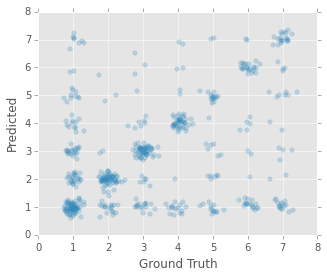

In [1328]:
plt.figure(figsize=(5, 4))

plt.scatter(jitter(dev.Category, 0.15),
            jitter(dev_predicted, 0.15),
            color='#348ABD', alpha=0.25)

plt.xlabel('Ground Truth')
plt.ylabel('Predicted')

## Testing

In [1329]:
training = training.append(sample(training))
training.reset_index(drop=True, inplace=True)

In [1330]:
training_matrix, test_matrix = tfidf_matrices(training, test)

In [1331]:
training = concat_tfidf(training, training_matrix)
test = concat_tfidf(test, test_matrix)

In [1332]:
features = training.columns[3:]

In [1333]:
X = training[features].values
y = training['Category'].values

In [1334]:
features_test = test[features].values

In [1335]:
svm.fit(X, y)
test_predicted = svm.predict(features_test)

In [1336]:
test['Category'] = test_predicted

In [1337]:
output = test[['Id', 'Category']]

In [1338]:
 #output.to_csv('../data/solution06.csv', index=False)